## Setup

In [1]:
import os
import configparser

import geopandas as gpd
import h3
from shapely.geometry import Point, Polygon

import pandas as pd

import matplotlib.pyplot as plt

In [47]:
#set filepaths
project_root = os.path.abspath(os.getcwd())
root = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))
config_file =  os.path.join(root, 'config.cfg')

# geodata for shapefiles
config = configparser.ConfigParser()
config.read(config_file)
gdata_root = config['geodata']['path']

## Load data

### Load shapefiles

Convert multipolygon to polygon first. Code from [this post](https://staedi.github.io/posts/multipolygon)

In [32]:
import json
filename = os.path.join(gdata_root, 'london-shapefiles\\london-no-river.geojson')
target_len = 15
 
js = open(filename, 'r').read()
gj = json.loads(js)
output = {"type":"FeatureCollection","features":[]}
 
def process_geojson(filename):
    js = open(filename, 'r').read()
    gj = json.loads(js)
    output = {"type":"FeatureCollection","features":[]}
 
    for feature in gj['features']:
        if feature['geometry'] is not None:
            if feature['geometry']['type'] == 'MultiPolygon':
                len_list = sorted([[idx, len(elem[0])] for idx, elem in enumerate(feature['geometry']['coordinates'])],key=lambda x: x[1],reverse=True)[:target_len]
                reg_len = [i[0] for i in len_list]
 
                for idx, poly in enumerate(feature['geometry']['coordinates']):
                    if len(feature['geometry']['coordinates'])<target_len or idx in reg_len:
                        xfeature = {"type":"Feature", "properties":feature["properties"], "geometry":{"type":"Polygon"}}
                        xfeature['geometry']['coordinates'] = poly
                        output['features'].append(xfeature)
            else:
                for idx, poly in enumerate(feature['geometry']['coordinates']):
                    xfeature = {"type":"Feature", "properties":feature["properties"], "geometry":feature["geometry"]}
                    output['features'].append(xfeature)
 
    open(filename, 'w').write(json.dumps(output,separators=(',',':'),ensure_ascii=False).replace('}},','}},\n'))
 
process_geojson(filename)

In [48]:
# read London shapefile and reproject to coordinate system to match grid
london_all = gpd.read_file(os.path.join(gdata_root, 'london-shapefiles\\london-no-river.geojson'))

# load river shapefile
river = gpd.GeoDataFrame.from_file(os.path.join(gdata_root, 'london-shapefiles\\river-thames-clipped.geojson'))

### Load accident data

From DfT. 

In [3]:
# dictionary to map codes to labels
labels =  pd.read_excel("dft-road-casualty-statistics-road-safety-open-dataset-data-guide-2022.xlsx")

In [5]:
# load data sets
data = {"vehicle":[], "casualty":[],  "collision":[]}

for dataset in data.keys():
    files = []
    files.append( "dft-road-casualty-statistics-%s-2022.csv"%(dataset)) 
    for filename in files:
        df = pd.read_csv(filename, low_memory=False)
        data[dataset].append(df)
    data[dataset] = pd.concat(data[dataset], axis=0, ignore_index=True)
    data[dataset]["accident_index"] = data[dataset]["accident_index"].astype(str)

## Process data

### get hexagons for London

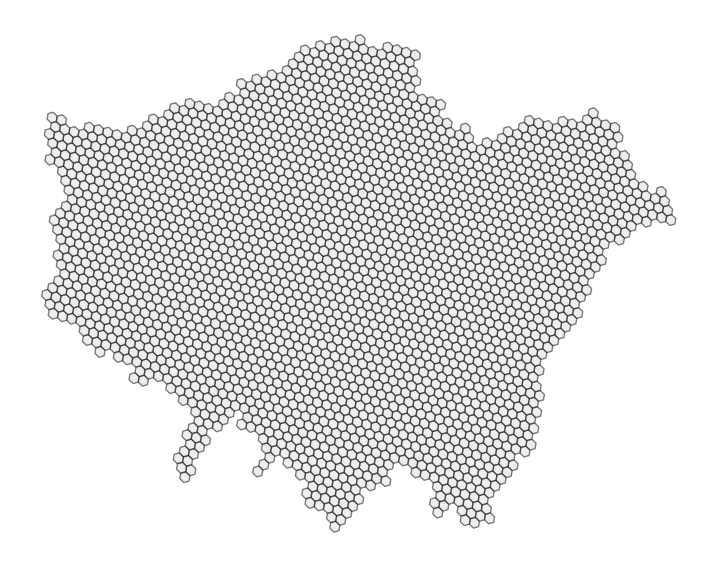

In [49]:
#Get all polygons that intersect our area of interest
hexs = h3.polyfill(london_all["geometry"].iloc[0].__geo_interface__, 8, geo_json_conformant = True)

#Set up a simple lambda function that makes the geo_boundary call from a hex id
polygonise = lambda hex_id: Polygon(h3.h3_to_geo_boundary(hex_id, geo_json=True))

#Create a geodataframe and populate the geometrie field with the result of the polygonise function with the hexs variable for input
all_polys = gpd.GeoSeries(list(map(polygonise, hexs)), index=hexs, crs="EPSG:4326")

#Plot to see how it looks
ax = all_polys.plot(alpha=0.5, color="#DEDEDE", edgecolor="black", figsize=(9, 9))
ax.axis("off")
plt.show()

In [50]:
# convert to geodataframe to join with points data later
gdf_poly = gpd.GeoDataFrame(crs = 'EPSG:4326', geometry=all_polys)
gdf_poly = gdf_poly.reset_index().rename(columns={"index": "name"})
gdf_poly.head()

,name,geometry
0,88194ac03dfffff,"POLYGON ((-0.14388 51.31774, -0.15057 51.31653..."
1,88194e61e3fffff,"POLYGON ((0.18858 51.57662, 0.18188 51.57545, ..."
2,88194ac335fffff,"POLYGON ((-0.18157 51.36640, -0.18826 51.36519..."
3,88195da763fffff,"POLYGON ((-0.23843 51.65013, -0.24516 51.64893..."
4,88194e6905fffff,"POLYGON ((-0.06305 51.61313, -0.06977 51.61195..."


In [ ]:
# save as geojson to use at later point



### Prepare accident data

In [27]:
# group vehicle types
classes = {0: "Pedestrian", 1 : "Pedal cycle", 2: "Motorbike", 3: "Motorbike", 4: "Motorbike", 5: "Motorbike", 
                 97: "Motorbike", 8: "Car",  9: "Car", 10: "Bus", 11: "Bus", 16: "Other", 17: "Other", 18: "Tram",
                19: "Van", 20: "Heavy", 21: "Heavy", 22: "Scooter", 23: "Electric motorcycle", 90: "Other",
                98: "Heavy", 99: "Other" }

# relevant columns from collision
coll_cols = ['accident_index', 'accident_year', 'longitude', 'latitude', 'accident_severity', 'number_of_vehicles',
            'number_of_casualties', 'date', 'day_of_week', 'time','local_authority_ons_district', 'first_road_class', 
            'road_type','speed_limit', 'junction_detail',]

In [34]:
# reduce dataframe to relevant columns
df = data["collision"][coll_cols]

# match codes against labels
for column in ["accident_severity", "day_of_week", 'first_road_class', 'road_type', 'junction_detail',]:
    _filter = labels["field name"]==column
    df.loc[:, column] = df.loc[:, column].map(dict(zip(labels[_filter]["code/format"], labels[_filter]["label"])))

In [35]:
# merge with vehicles
data["vehicle"]["vehicle_group"] = data["vehicle"]["vehicle_type"].map(classes)
veh_involved = data["vehicle"].groupby(["accident_index",
                                 "vehicle_group"])["accident_index"].count().unstack().reset_index().fillna(0)
df = pd.merge(df, veh_involved, left_on="accident_index", right_on="accident_index", how="left")

In [36]:
# merge with casualties
data["casualty"]["casualty_group"] = data["casualty"]["casualty_type"].map(classes)
cas_caused = data["casualty"].groupby(["accident_index",
                                 "casualty_group"])["accident_index"].count().unstack().fillna(0)
cas_caused = cas_caused.add_prefix('Cas_').reset_index()
df = pd.merge(df, cas_caused, left_on="accident_index", right_on="accident_index", how="left")

In [39]:
# convert to geo dataframe
geometry = [Point(xy) for xy in zip(df['longitude'].astype(float), df['latitude'].astype(float))]
gdf = gpd.GeoDataFrame(df, crs = 'EPSG:4326', geometry = geometry)

### More processing

In [107]:
# filter for cycle accidents
_filter = gdf["Pedal cycle"]>0
gdf_filtered = gdf[_filter].reset_index(drop=True)

#  #merge data to hexgrid
merged = gpd.sjoin(gdf_filtered, gdf_poly, how='left')

# make a count variable that we can sum per grid cell
merged['collisions']=1
dissolve = merged.dissolve(by='index_right', aggfunc='count')

# include count in fishnet
gdf_poly.loc[dissolve.index, 'collisions'] = dissolve['collisions'].values

## Visualise

In [108]:
# dictionary of places to map
places = { 'Shoreditch': [51.522958723664935, -0.07766412768674981],
             'Camden': [51.53955149862139, -0.14262241669039177],
             'Soho': [51.51309688360682, -0.13491248421579607],
             'Hammersmith': [51.49223618549943, -0.22361215911733306],
             #'Kingston':[51.41005356527376, -0.30761369381871223],
             'Clapham':[51.46175333629983, -0.13824969876097923],
             #'Richmond':[51.45930825530233, -0.3056528356679942],
             'Camberwell': [51.474130682653644, -0.09310103554433165],
            # 'Bromley': [51.404040001513586, 0.016439934862091166],
             #'Sutton': [51.36439196566658, -0.19218816484096937],
            # 'Croydon':[51.374244431071716, -0.10021148332449809],
             #'Finchley':[51.61244855213473, -0.17340662821177052],
            # 'Ealing':[51.51422792569118, -0.29740243602398153],
             'Dalston':[51.548199640025466, -0.0754982857534403],
             'Tooting':[51.427777560713466, -0.16763313756420725],
             'Holloway':[51.552883212571786, -0.11286608071955605],
            # 'Stratford':[51.54248675328208, 0.005191726952792273],
             "Elephant & Castle": [51.49469468571915, -0.10030285876338756],
             "Vauxhall":[51.48618195698862, -0.12316154264544815]
         }
places = pd.DataFrame.from_dict(places, orient='index', columns=['lat', 'lon'])
geometry = [Point(xy) for xy in zip(places['lon'].astype(float), places['lat'].astype(float))]
places = gpd.GeoDataFrame(places, crs = '4326', geometry = geometry)

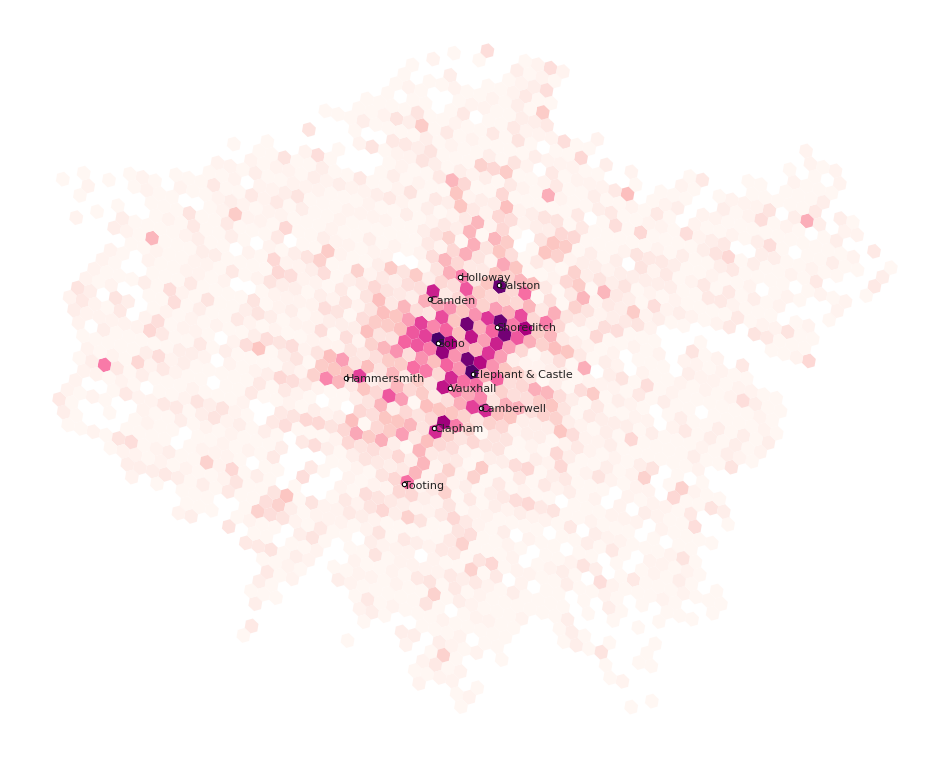

In [111]:
fig, ax = plt.subplots(figsize=(12, 10))
gdf_poly.plot(ax=ax, column="collisions", alpha=1, zorder=2, cmap='RdPu')
places.plot(ax=ax, markersize=10,zorder=2, color='white', edgecolor='black', linewidth=0.75)
for i in range(len(places)):
    ax.text(places['geometry'].iloc[i].x, places['geometry'].iloc[i].y, places.index[i],
            va='center_baseline', ha='left', fontsize=8, color='#222222')
ax.axis("off")

plt.show()

## Analyse

<Axes: >

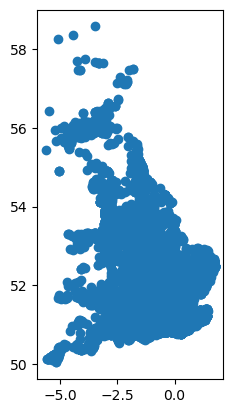

In [41]:
gdf[gdf["Pedal cycle"]>0].plot()